# Computer Homework 8: Simulating trajectories of charged particles in electric and magnetic fields

#### Due at the beginning of class on Thursday, Nov. 1

In this excercise we will simulate how particles move in electric and magnetic fields. The charged particles will move in response to a force, which causes an acceleration, which in turn changes the velocity and position.  The motion will depend on the initial position and velocity. 

### Import the usual libraries

In [11]:
import numpy as np                         ## numpy is a library that includes most of the numerical function you will need
import matplotlib.pyplot as plt            ## this is the library we use to plot   
from mpl_toolkits.mplot3d import Axes3D    ## this is a library to plot in 3d

First we define a function to specify the $E$ and $B$ fields as a function of position. You can edit this function to describe different field arrangements.

In [15]:
def get_EB(r):
    '''
    This function returns the E and B fields for a specified situation as a function of position.
    Input: r -- position vector: a numpy array of 3 values, e.g. np.array([x,y,z])
    Returns: E,B -- 3-vectors of E- and B-field values at r.
    '''
    x = r[0]
    y = r[1]
    z = r[2]
    
#### Uncomment the appropriate line to do the examples below.
## REMEMBER to execute this cell for your changes to take effect!

## Example 1: parallel, constant fields along the x-axis:
#    E = np.array([4,0,0])
#    B = np.array([2,0,0])
## Example 2: crossed E- and B-fields:
    E = np.array([1,0,0])
    B = np.array([0,1,0])
## Part 3: Define your fields for Part 3 here.
#

## Part 4: Define your (zero) E-field and (position-dependent) B-field for Part 4 here.
# 
    return E,B



In the next cell we define a function to calculates the trajectory of a particle in an electromagnetic field.   Take time to understand how it works.  This will be in cartesian coordinates, and we evaluate the components of the cross product in $\vec F = q (\vec E + \vec v \times \vec B)$ and write them out explicitly.

In [13]:
def calc_trajectory(r0,v0,q,m,dt,Nstep, more_accurate=False):
    '''
    Calculates the trajectory of a particle in an electromagnetic field. The electromagnetic field must
    be specified in the get_EB() function defined above.
    Input:
    r0 -- numpy array of initial position, e.g. r0 = np.array([0,0,0]) for a particle that starts at the origin
    v0 -- numpy array of initial velocity, e.g. v0 = np.array([0,0,0]) for a particle that starts at rest
    q, m -- particle charge and mass
    dt -- time step
    Nstep -- number of time steps to integrate
    Returns:
    r -- array of positions, with shape (Nstep,3)
    v -- array of velocities, with shape (Nstep,3)
    t -- corresponding array of times, with shape (Nstep)
    more_accurate (Boolean, default=False) -- integrate using the standard Euler method (False), or via a second-order
                                                Runge-Kutta method (True), which is more accurate but more complicated.
    '''
    Nstep = int(Nstep)      # make sure Nstep is an integer
    r = np.zeros([Nstep,3])   # array of positions (x,y,z) at each timestep
    v = np.zeros([Nstep,3])   # array of velocities (vx,vy,vz) at each timestep
    t = np.zeros(Nstep)
    r[0,:] = r0             # fill first element with initial values
    v[0,:] = v0
    i = 0
    while i < Nstep-1:
        current_pos = r[i,:]
        current_vel = v[i,:]
        
        E,B = get_EB(current_pos) 
        a = q*(E + np.cross(current_vel,B))/m
        
        if more_accurate:    # implements a second-order Runge-Kutta integration
            mid_vel = current_vel + a*dt/2.
            mid_pos = current_pos + mid_vel*dt/2.
            E2, B2 = get_EB(mid_pos)
            a2 = q*(E2 + np.cross(mid_vel,B2))/m
            next_vel = current_vel + a2*dt
            next_pos = current_pos + mid_vel*dt
        else:               # the usual Euler's method
            next_pos = current_pos + current_vel*dt
            next_vel = current_vel + a*dt
            
        v[i+1,:] = next_vel
        r[i+1,:] = next_pos
        t[i+1] = t[i] + dt
        i+=1

    return r,v,t
    

## Example 1: Particle in a parallel E and B field

This simulation simulates the trajectory of an electron in an electric and magnetic field that happen to be parallel. The particle is given an initial velocity perpendicular to the fields. Run this code to generate the graphs.   There are several discussion questions below. Make sure the appropriate line is uncommented in the ```get_EB()``` function above.

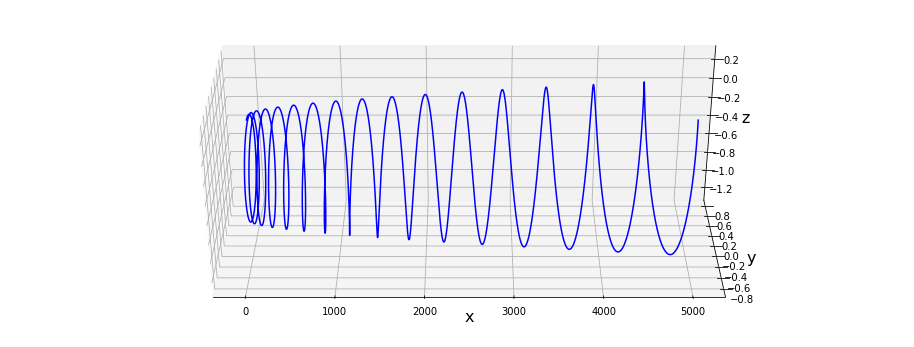

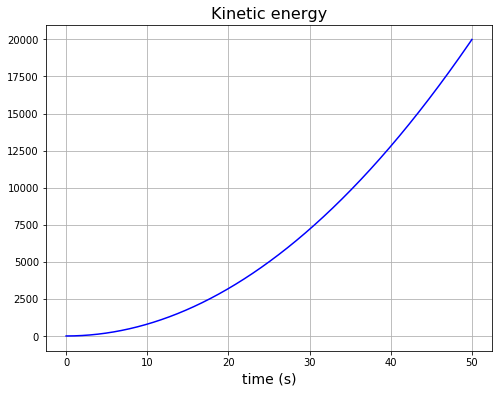

In [14]:
# Example with parallel E and B fields.  
# Make sure the appropriate lines are uncommented in the get_EB() function above.
#
# Particle starts at origin and is moving in the +y direction:
r0 = np.array([0,0,0])
v0 = np.array([0,1,0])
q = 1.
m = 1.
delta_t = 0.005
N = 1e4

r,v,t = calc_trajectory(r0,v0,q,m,delta_t,N)
x = r[:,0]
y = r[:,1]
z = r[:,2]

### make some plots

fig = plt.figure(1, figsize=(16,6))
ax = fig.gca(projection='3d')
ax.view_init(30,-90)
ax.plot(x,y,z, color='b')
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.set_zlabel('z', fontsize=16)

fig, ax = plt.subplots(1, figsize=(8,6))
KE = 0.5*m*np.linalg.norm(v**2, axis=1)
ax.plot(t, KE, color='b')
ax.set_title("Kinetic energy", fontsize=16)
ax.grid()
xlab = ax.set_xlabel('time (s)', fontsize=14)

## Part 1 (10 points)  discussion questions:

#### (1) Explain why the trajectory looks the way it does.

#### (2) Explain why the kinetic energy grows the way it does.

#### (3) Describe what happens when you double the strength of the E-field.

#### (4) Describe what happens when you double the strength of the B-field.


## Example 2: Particle in a crossed E and B field

This simulation simulates the trajectory of an electron in an electric and magnetic field that happen to be perpendicular.  The particle starts from rest. Run this code to generate the graphs.  There are several discussion questions below. Make sure the approriate lines are uncommented in the ```get_EB()``` function above.

Text(0.5,1,'particle trajectory in x-z plane')

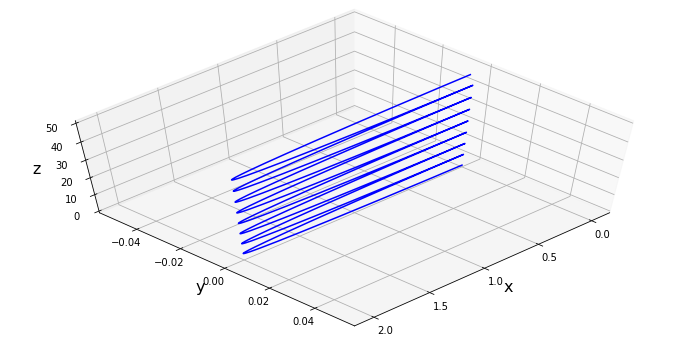

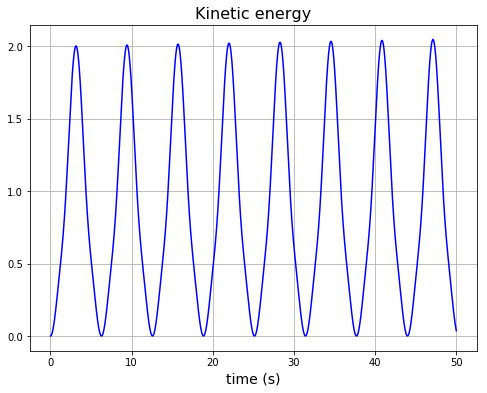

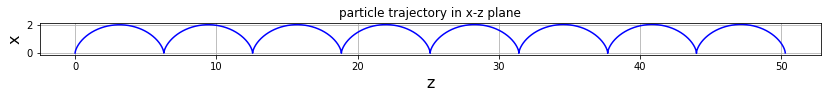

In [16]:
# This is the similar to the previous example; only the initial conditions have changed.
# Make sure the approriate lines are uncommented in the get_EB() function above.

## Particle starts at rest at the origin.
r0 = np.zeros(3)
v0 = np.zeros(3)
q = 1.
m = 1.
delta_t = 0.001
N = 5e4

r,v,t = calc_trajectory(r0,v0,q,m,delta_t,N)

x = r[:,0]
y = r[:,1]
z = r[:,2]
### make some plots

fig = plt.figure(1, figsize=(12,6))
ax = fig.gca(projection='3d')
ax.view_init(60,45)
ax.plot(x, y, z, color='b')
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.set_zlabel('z', fontsize=16)

fig, ax = plt.subplots(1, figsize=(8,6))
KE = 0.5*m*np.linalg.norm(v**2, axis=1)
ax.plot(t,KE,color='b')
ax.set_title("Kinetic energy", fontsize=16)
ax.grid()
xlab = ax.set_xlabel('time (s)', fontsize=14)

fig, ax  = plt.subplots(1, figsize=(14,4))
ax.plot(z, x, color='b')
ax.set_aspect('equal')
ax.set_xlabel('z', fontsize=16)
ax.set_ylabel('x', fontsize=16)
ax.grid()
ax.set_title("particle trajectory in x-z plane")

## Part 2 (10 points)  discussion questions:

#### (1) Explain why the trajectory looks the way it does.

#### (2) Explain why the kinetic energy look the way it does.


#### (3) Describe what happens when you double the strength of the E-field.


#### (4) Describe what happens when you double the strength of the B-field.


## Part 3 (10 points): The velocity filter
   

Consider a particle with charge 1 C and mass 1 kg moving with velocity $v = (1~\mathrm{m/s})~\hat x$.  If this particle enters a region with a magnetic field $B = (1~\mathrm{T})~\hat y$, then clearly it will experience a force.   You can calculate it by hand quite easily.    You could then create an electric field to perfectly oppose this magnetic force.   If you set up this field configuration you would have a "velocity filter." 

#### (1) Calculate the magnitude of the E field you need to oppose the B field described above, and modify the ```get_EB()``` function accordingly. 


#### (2) Set up a simulation and show that your calculation is correct.

#### (3) Re-run the simulation changing the velocity of the particle to be larger and smaller than what you found above.   



(1) Write your equations here.



In [ ]:
##(2) Set up your simulation here and plot the results


Your discussion here.

In [ ]:
##(3) Set up your simulations with larger and smaller velocities

Your discussion here.

## Part 4 (10 points): Motion in non-uniform magnetic field
For this problem the magnetic field will not be uniform, instead it is going to be changing as a function of position.  The magnetic field in cylindrical coordinates is:
\begin{equation}
 B(r,\phi,z) = - \frac {B_1} {2} r \hat{r} + (B_0 + B_1z)\hat{z}
\end{equation}

That is the the magnitude of the field is changing in $z$ and $r$, but is not changing in $\phi$.  You should make $B_0$ about 10 times as big as $B_1$, that is if $B_0$ is 1 T then $B_1$ should be 0.1 T/m.

Take the electric field to be zero.

In case you are curious... yes, this is a field that obeys Maxwell's equations. Such a field could not really fill all space... it blows up as $r\rightarrow\infty$. However, this field could exist inside a long, cylindrical coil of wire (a solenoid) where the number of turns per meter is increasing linearly. Such fields are sometimes used at particle accelerators to guide beams of charged particles.

#### 1) Rewrite the B-field in cartesian coordinates.

#### 2) Write a simulation for  a particle moving in this field.  You will need to add code to ```get_EB()``` to describe this position-dependent field. Explore the effects of changing the integration method by setting ```more_accurate=True```. How does the kinetic energy behave in each case?

#### 3) Discuss your results. 


#### 1. The field in cartesian coordinates goes here


In [ ]:
# 2. your code goes here.

#### 3. Your discussion goes here